<a href="https://colab.research.google.com/github/MaschinenNah/FramePredictionProject/blob/main/frame_predictor_210715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Package ml_utils laden und importieren

In [1]:
!git clone https://github.com/MaschinenNah/ml_utils
from ml_utils import load
from ml_utils import show
from ml_utils import frame_predict as fp

Cloning into 'ml_utils'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 121 (delta 56), reused 85 (delta 27), pack-reused 0
Receiving objects: 100% (121/121), 14.38 KiB | 7.19 MiB/s, done.
Resolving deltas: 100% (56/56), done.


### Daten laden

In [2]:
#zip_url = "http://pitnoack.de/mn/frame_pred_proc_zufaellige_formen/data.zip"
zip_url = "https://github.com/MaschinenNah/demo_daten/raw/main/50_scenes_48_48_sw.zip"
load.load_and_unzip_from_url(zip_url)

### Generator initialisieren

In [3]:
gen = fp.FramePredictionGenerator("/content/data/scenes", (48, 48), 8, 50)

### Generator visuell prüfen

x (50, 8, 48, 48)
y (50, 48, 48)


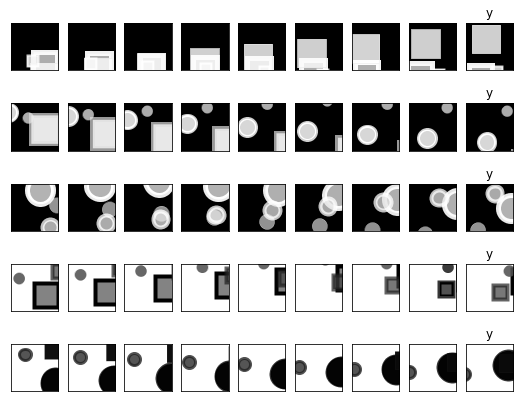

In [4]:
batch = gen[0]

print("x", batch[0].shape)
print("y", batch[1].shape)
show.show_frame_prediction_batch(batch, 5)

### GPU starten
(ist für den test der loss funktion irrelevant, denke ich...)

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 14 11:23:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Modell entwerfen

In [8]:
import numpy as np

from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

input_shape = (8, 48, 48)
output_shape = (48, 48)

input_layer = Input(shape=input_shape)

x = Flatten()(input_layer)

x = Dropout(0.2)(x)

x = Dense(2000, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(1000, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(1000, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(1000, activation="sigmoid")(x)

x = Dense(2304, activation="sigmoid")(x)

output_layer = Reshape(output_shape)(x)

model = Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 48, 48)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 2000)              36866000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0     

alternatives modell mit autoencoder

In [63]:
input_shape = (8, 48, 48)
output_shape = (48, 48)

input_layer = Input(shape=input_shape)

x = Flatten()(input_layer)

x = Dropout(0.2)(x)

x = Dense(2304, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(1000, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(500, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(250, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(500, activation="sigmoid")(x)

x = Dense(1000, activation="sigmoid")(x)

x = Dense(2304, activation="sigmoid")(x)

output_layer = Reshape(output_shape)(x)

model = Model(input_layer, output_layer)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 8, 48, 48)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 2304)              42469632  
_________________________________________________________________
dropout_11 (Dropout)         (None, 2304)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1000)              2305000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000)              0   

### Ein Modell, dass Unschärfe misst

In [44]:
from tensorflow.keras.layers import Conv2D, Reshape, Lambda, Add
import tensorflow as tf

input_shape = (48, 48)
output_shape = (1)

input_layer = Input(shape=input_shape)

x = Reshape((48, 48, 1))(input_layer)

x_kernel = Conv2D(name="x_kernel", filters=1, kernel_size=(3,3))(x)

y_kernel = Conv2D(name="y_kernel", filters=1, kernel_size=(3,3))(x)

x_quad = Lambda(lambda n : n*n)(x_kernel)

y_quad = Lambda(lambda n : n*n)(y_kernel)

x_and_y = Add()([x_quad, y_quad])

sum = tf.reduce_sum(x_and_y, axis=[1,2,3])

normalized = Lambda(lambda n : 1/n)(sum)

output_layer = normalized

blur_detect = Model(input_layer, output_layer)

x_kernel_weights = np.array([1,0,-1,2,0,-2,1,0,-1])
x_kernel_weights = x_kernel_weights.reshape((3, 3, 1, 1))
x_kernel_weights = [x_kernel_weights, np.array([0])]
blur_detect.get_layer("x_kernel").set_weights(x_kernel_weights)

y_kernel_weights = np.array([1,2,1,0,0,0,-1,-2,-1])
y_kernel_weights = y_kernel_weights.reshape((3, 3, 1, 1))
y_kernel_weights = [y_kernel_weights, np.array([0])]
blur_detect.get_layer("y_kernel").set_weights(y_kernel_weights)

### Optimierer setzen und Modell kompilieren

In [104]:
from scipy import ndimage
import tensorflow as tf


optimizer = Adam(learning_rate=0.00025)

def loss(y_true, y_pred):
  blurriness = K.sum(blur_detect(y_pred))
  unequality = K.mean(K.square(y_true - y_pred), axis = [1,2])
  idleness = 0;
  return 4 * unequality + 0.03 * blurriness

model.compile(loss=loss, optimizer=optimizer)

### Modell trainieren

In [ ]:
model.fit(gen, epochs=1000)

Epoch 1/1000
246/246 [==============================] - 31s 124ms/step - loss: 0.0892
Epoch 2/1000
246/246 [==============================] - 30s 122ms/step - loss: 0.0890
Epoch 3/1000
246/246 [==============================] - 30s 123ms/step - loss: 0.0895
Epoch 4/1000
246/246 [==============================] - 30s 123ms/step - loss: 0.0894
Epoch 5/1000
246/246 [==============================] - 31s 124ms/step - loss: 0.0891
Epoch 6/1000
246/246 [==============================] - 30s 124ms/step - loss: 0.0890
Epoch 7/1000
246/246 [==============================] - 30s 124ms/step - loss: 0.0894
Epoch 8/1000
246/246 [==============================] - 30s 123ms/step - loss: 0.0889
Epoch 9/1000
246/246 [==============================] - 30s 124ms/step - loss: 0.0891
Epoch 10/1000
246/246 [==============================] - 30s 123ms/step - loss: 0.0892
Epoch 11/1000
246/246 [==============================] - 30s 122ms/step - loss: 0.0888
Epoch 12/1000
246/246 [=============================

### Predictions ansehen

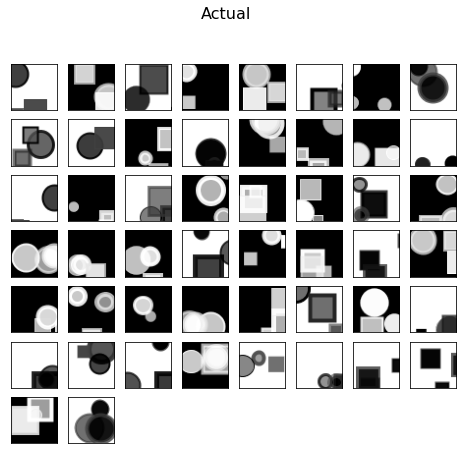

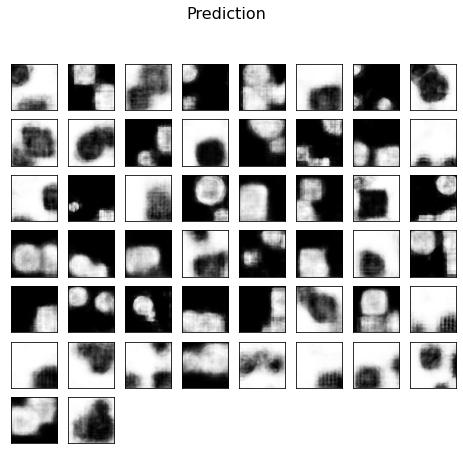

In [112]:
x = gen[0][0]
y = gen[0][1]
y_pred = model.predict(x)
show.show_images_from_np_array(y, "Actual")
show.show_images_from_np_array(y_pred, "Prediction")

### Hilfsfunktionen für Rückkopplung

In [40]:
def predict_single(model, input):
  input = input[np.newaxis, ...]
  output = model.predict(input)[0]
  return output

def dream_step(model, input):
  predicted_image = predict_single(model, input)
  
  output = np.empty_like(input)
  output[:-1] = input[1:]
  output[-1] = predicted_image
  return output

### TMP: acuity_detect testen

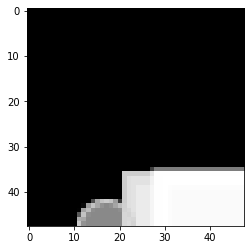

[2.831012]


In [ ]:
from matplotlib import pyplot as plt
bild = gen[0][1][6]
plt.imshow(bild, cmap="gray")
plt.show()
acuity = predict_single(acuity_detect, bild)
print(acuity)

In [41]:
bild = y_pred[1]
plt.imshow(bild, cmap="gray")
plt.show()
acuity = predict_single(acuity_detect, bild)
print(acuity)

NameError: ignored

### Film träumen

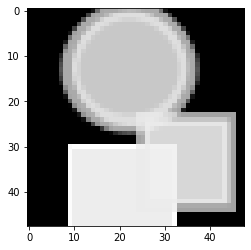

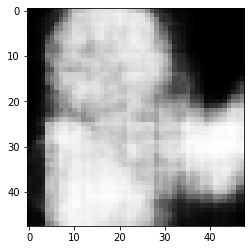

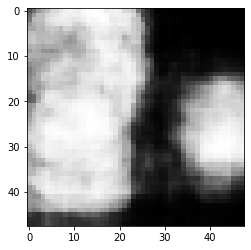

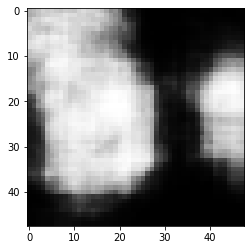

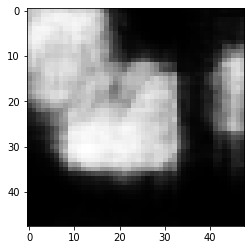

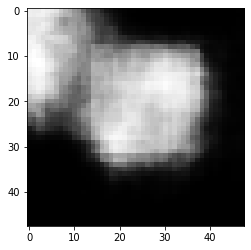

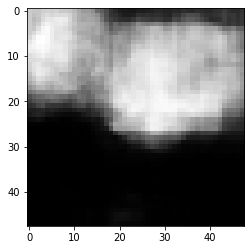

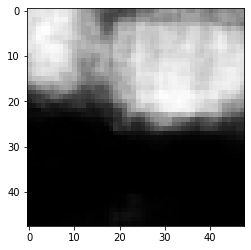

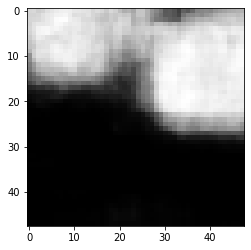

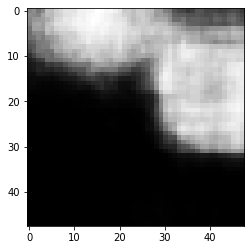

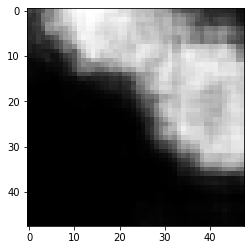

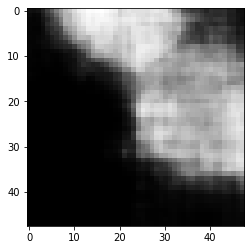

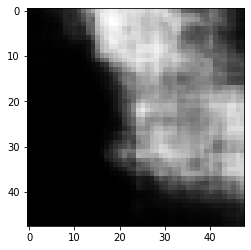

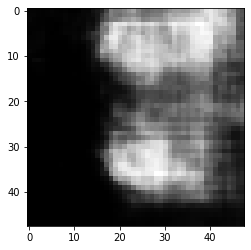

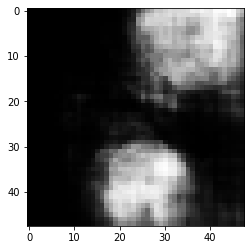

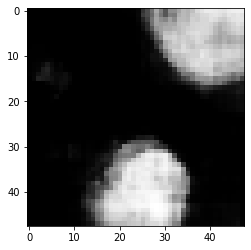

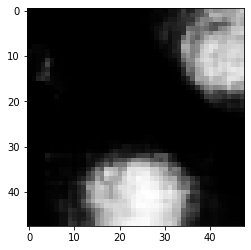

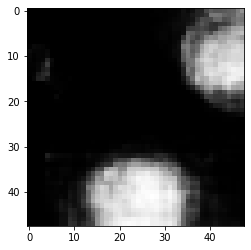

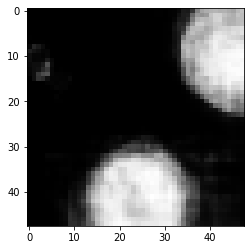

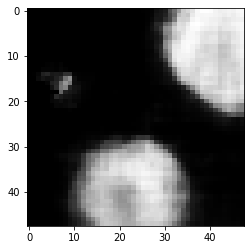

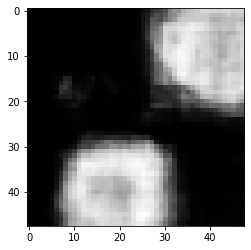

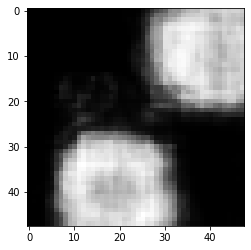

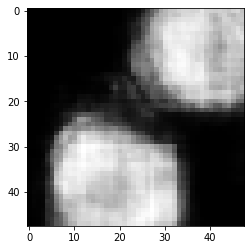

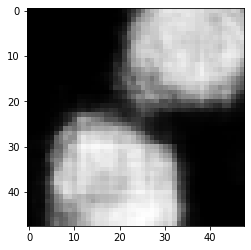

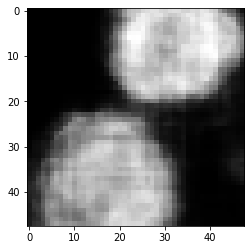

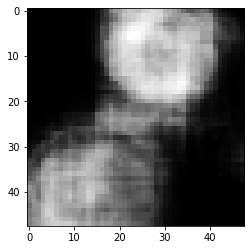

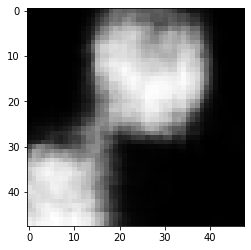

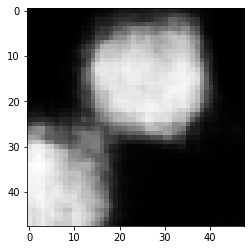

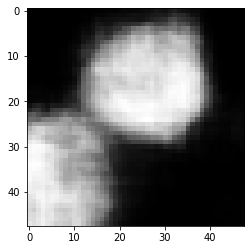

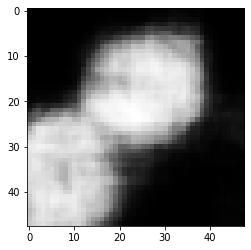

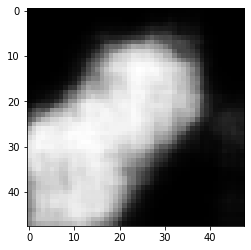

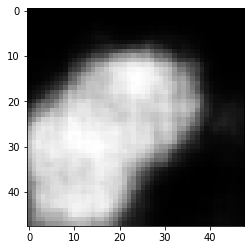

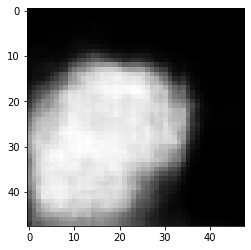

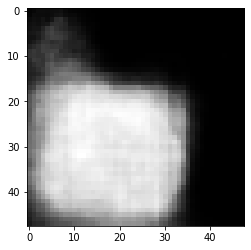

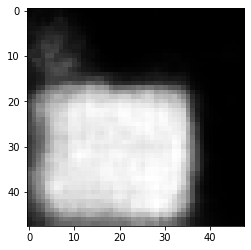

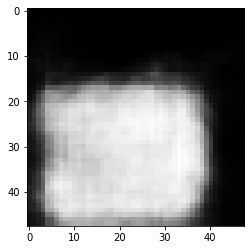

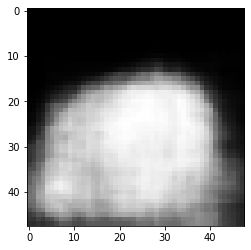

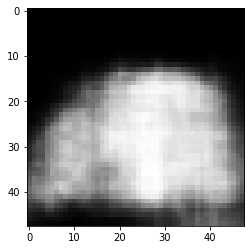

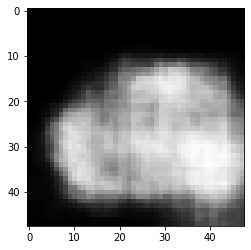

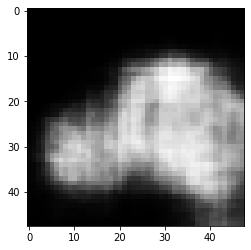

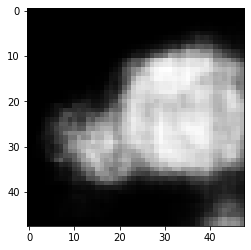

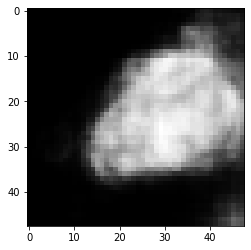

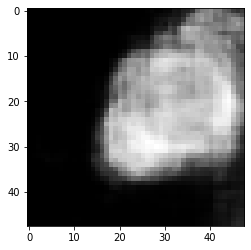

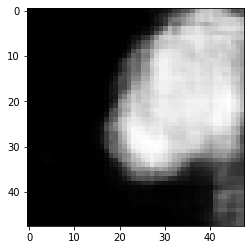

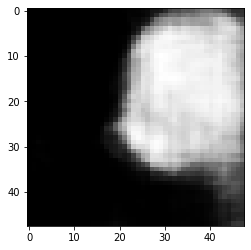

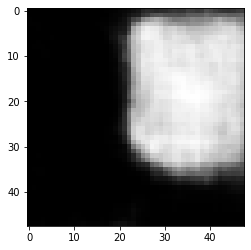

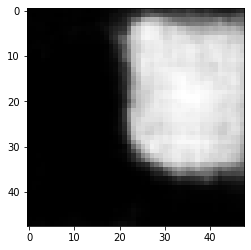

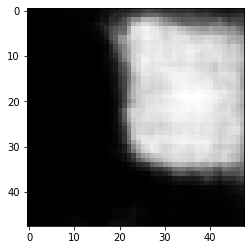

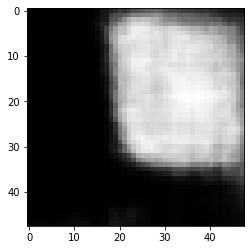

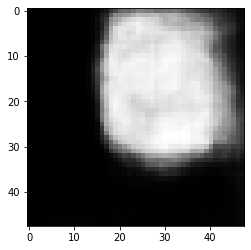

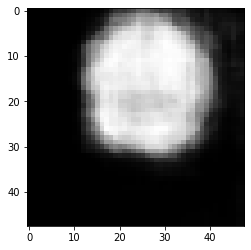

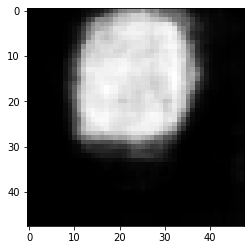

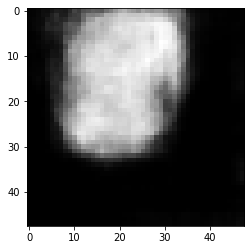

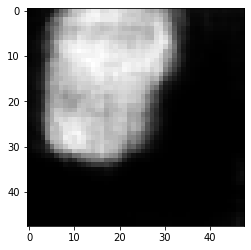

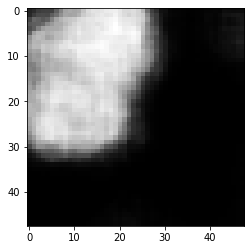

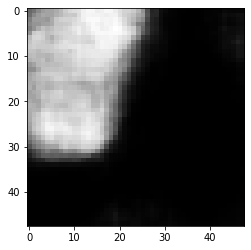

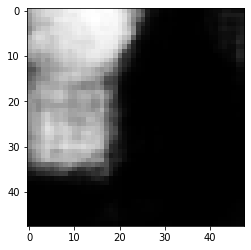

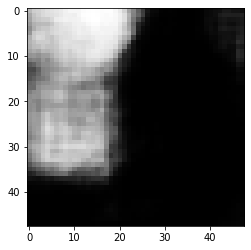

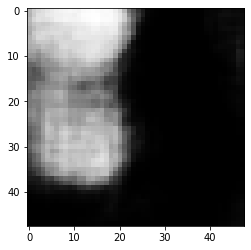

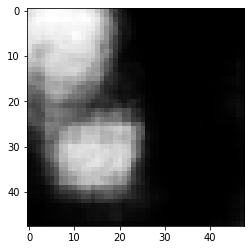

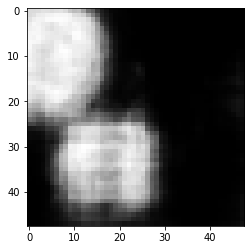

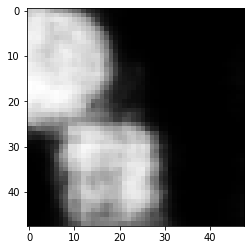

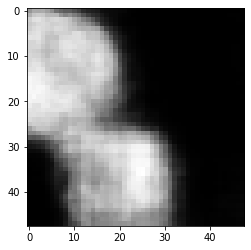

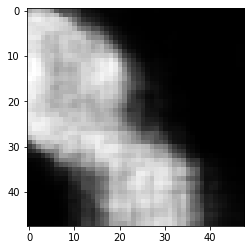

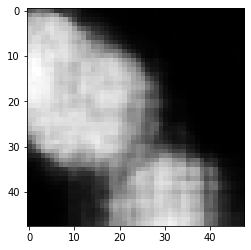

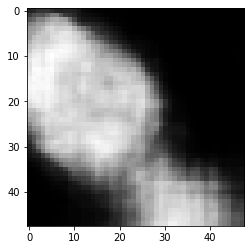

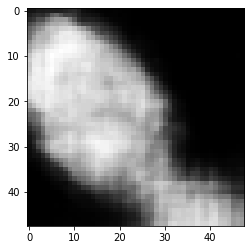

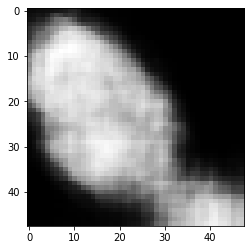

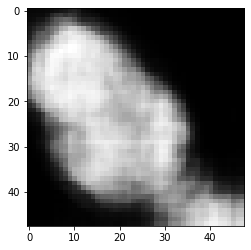

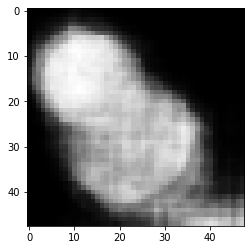

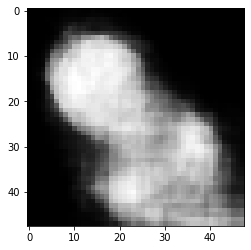

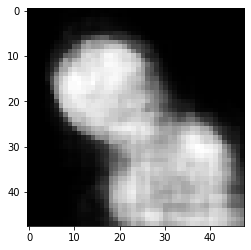

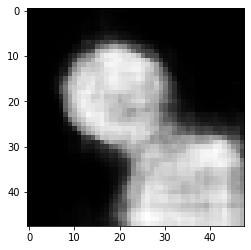

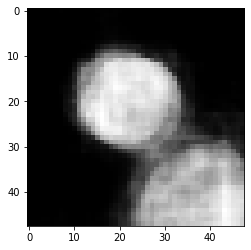

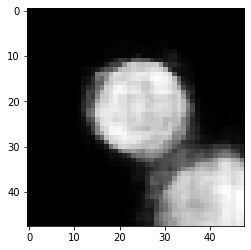

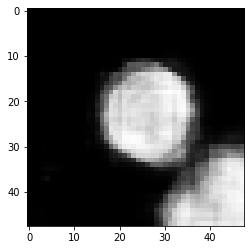

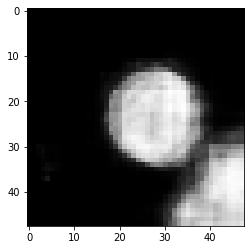

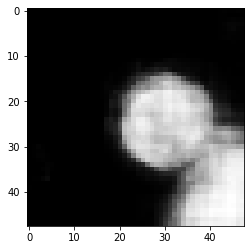

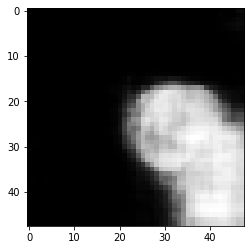

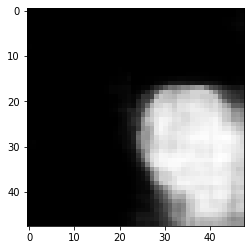

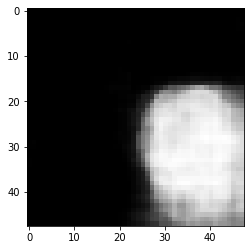

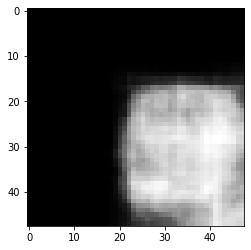

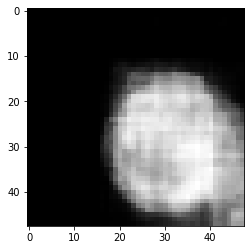

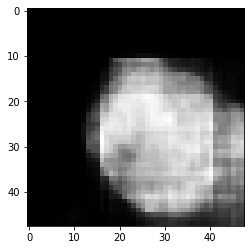

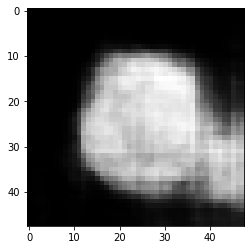

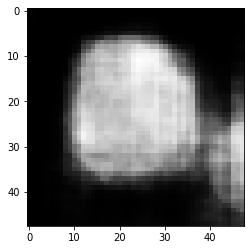

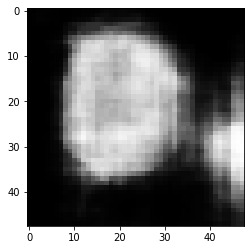

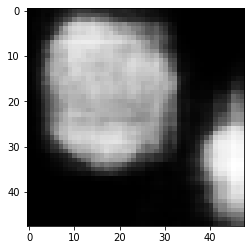

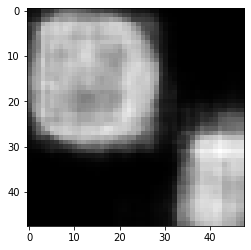

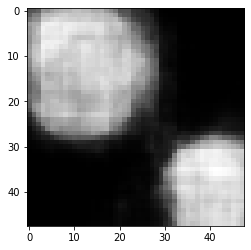

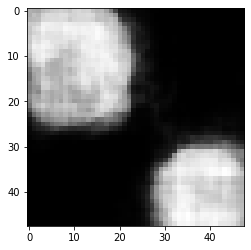

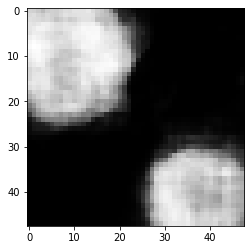

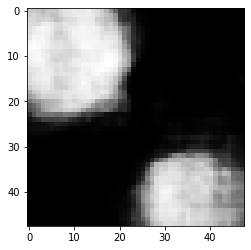

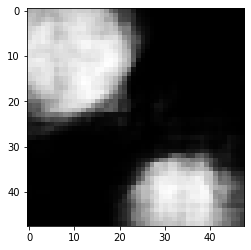

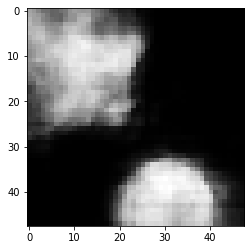

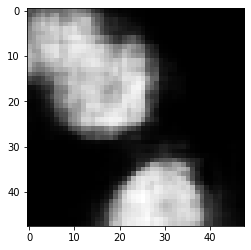

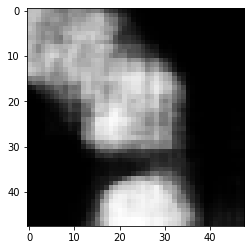

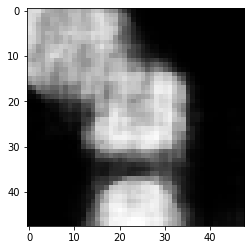

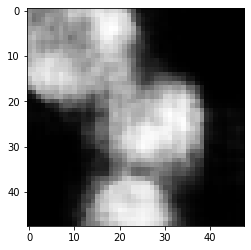

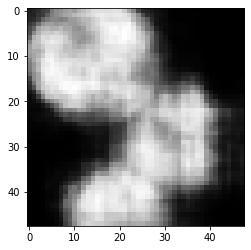

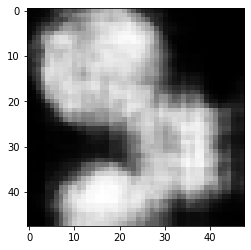

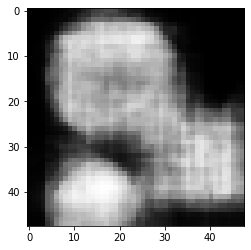

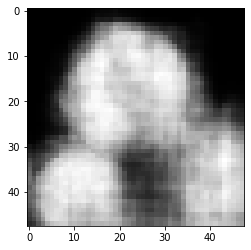

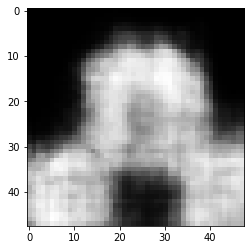

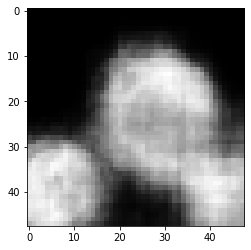

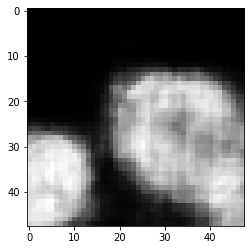

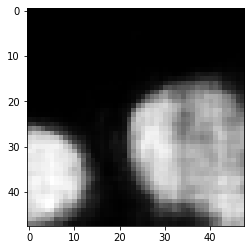

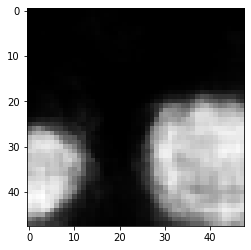

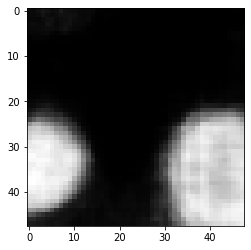

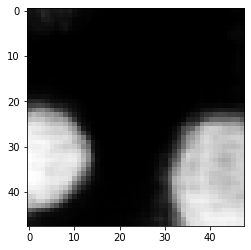

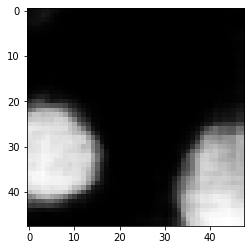

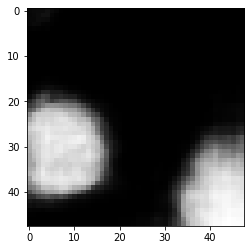

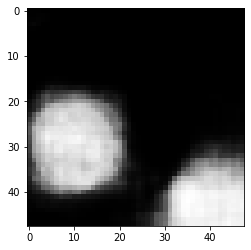

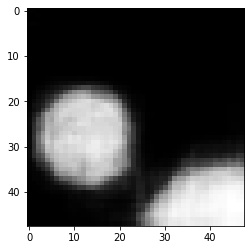

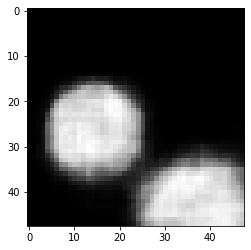

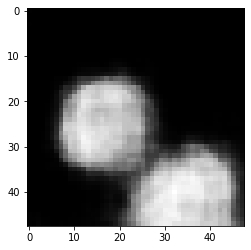

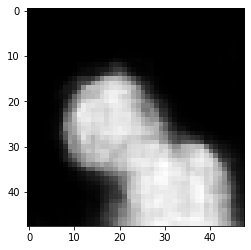

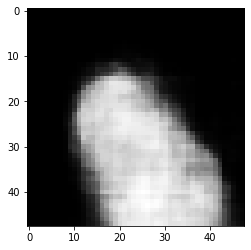

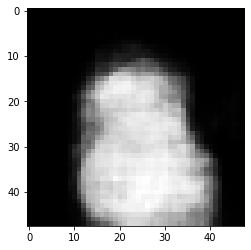

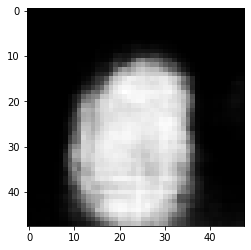

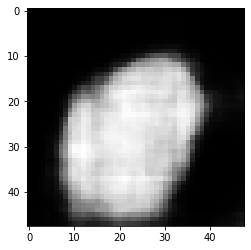

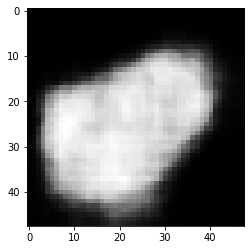

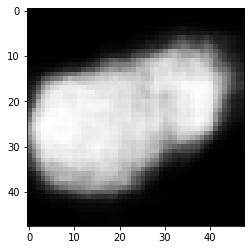

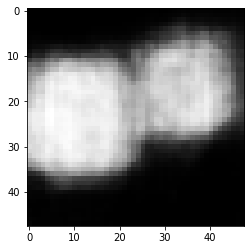

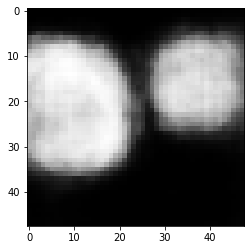

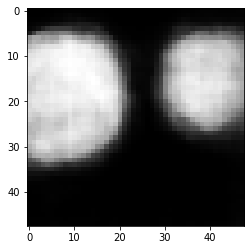

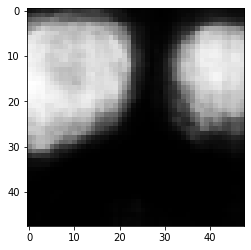

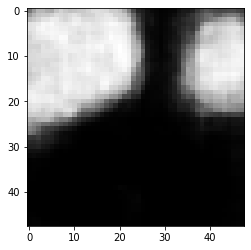

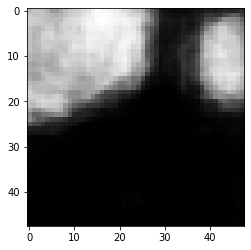

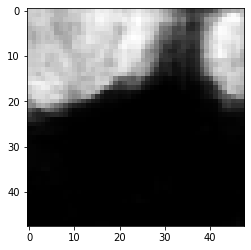

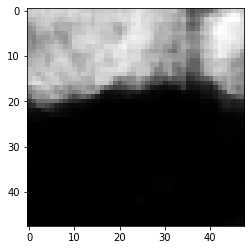

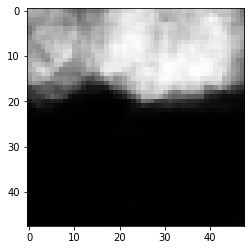

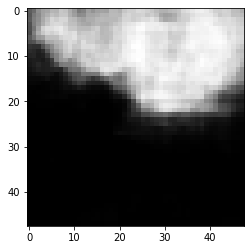

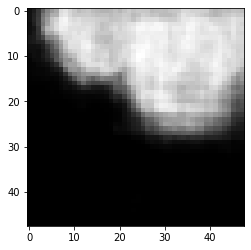

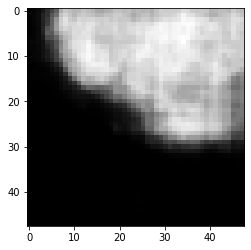

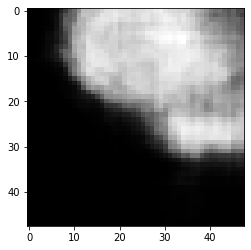

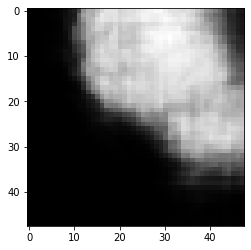

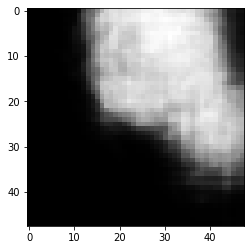

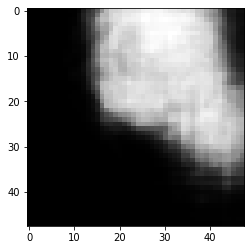

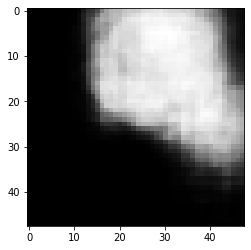

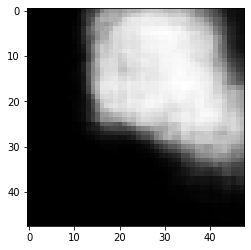

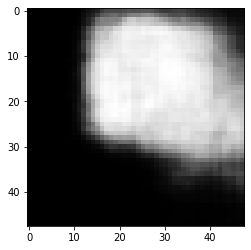

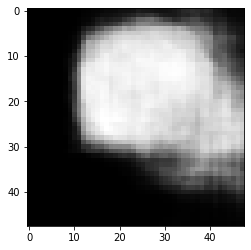

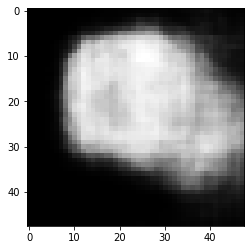

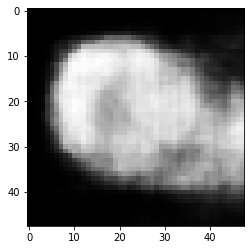

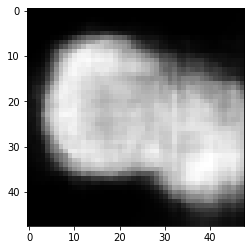

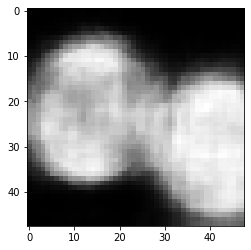

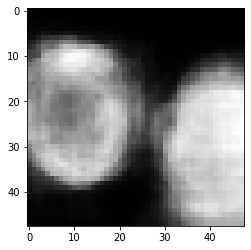

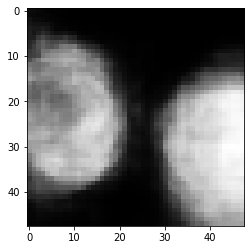

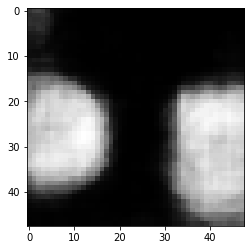

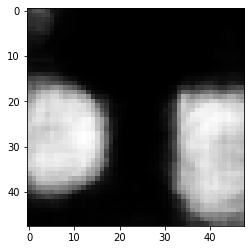

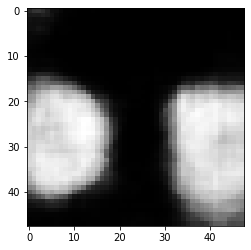

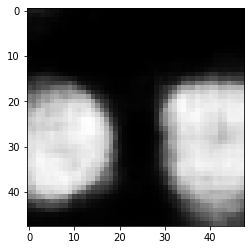

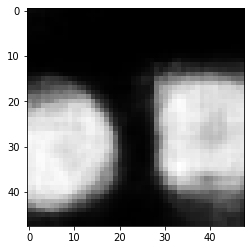

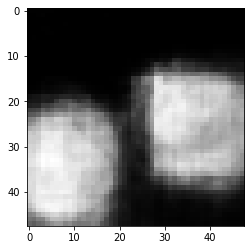

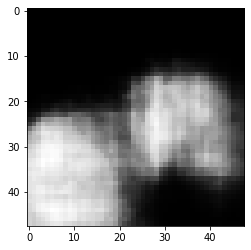

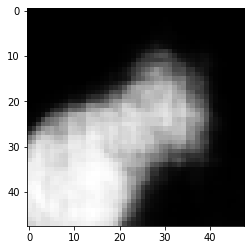

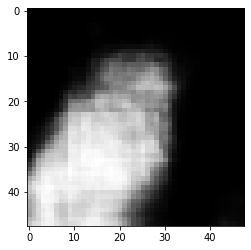

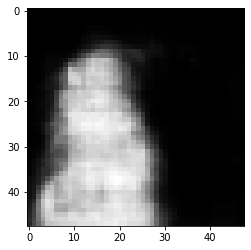

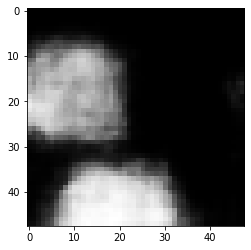

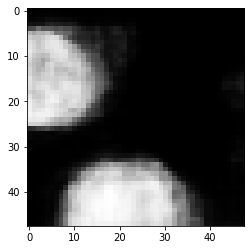

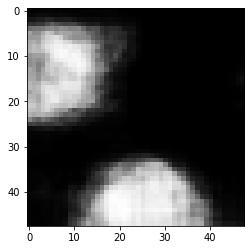

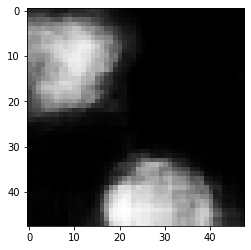

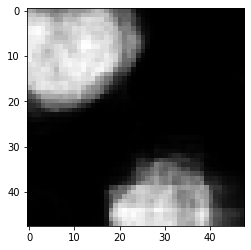

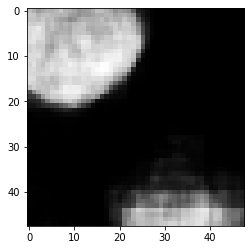

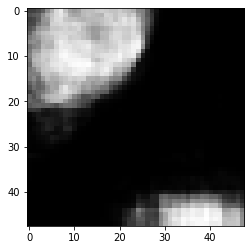

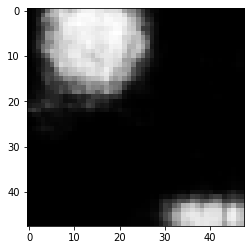

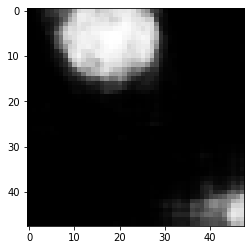

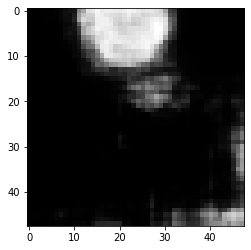

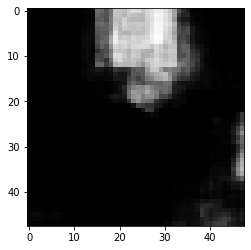

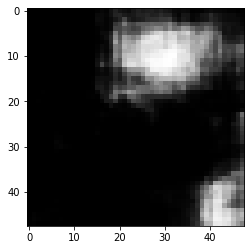

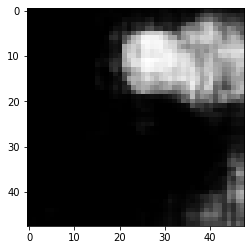

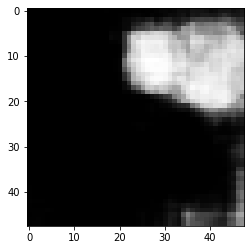

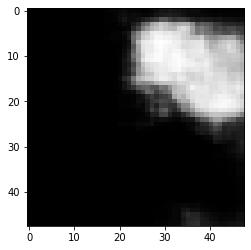

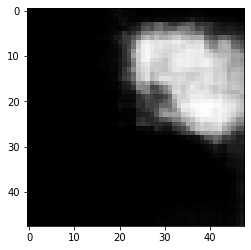

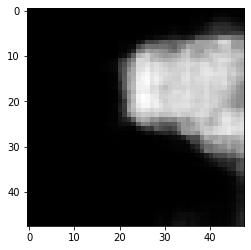

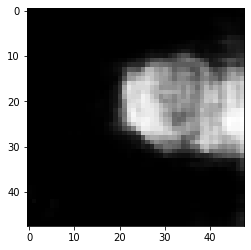

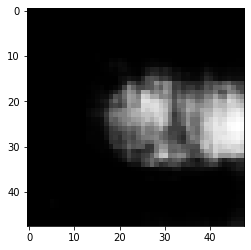

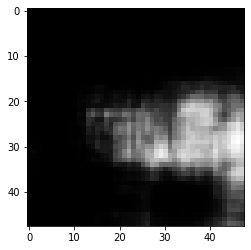

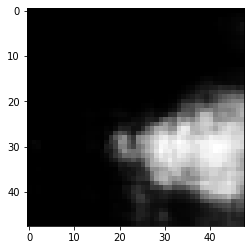

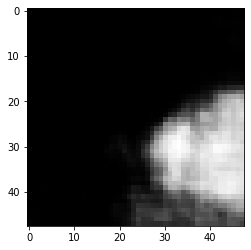

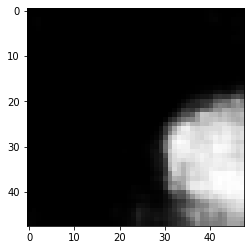

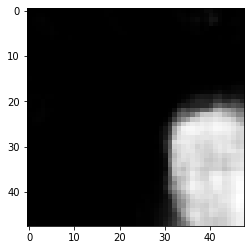

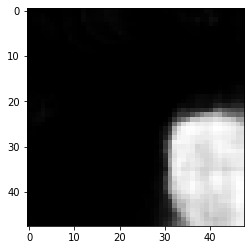

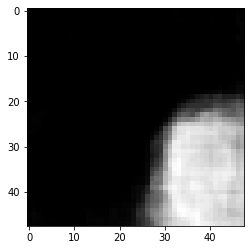

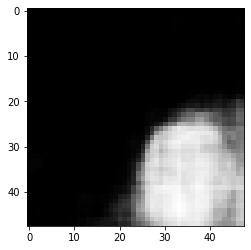

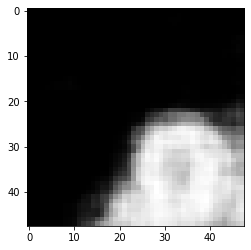

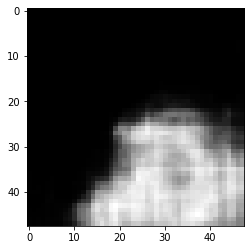

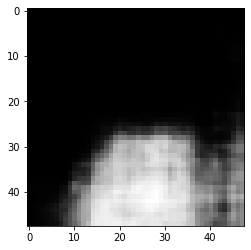

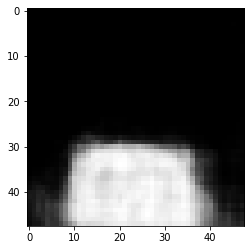

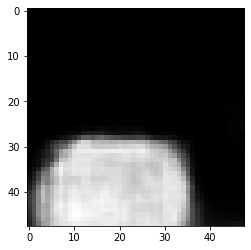

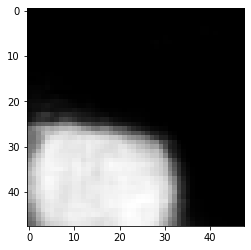

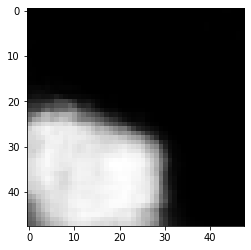

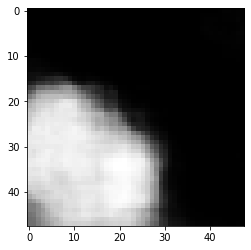

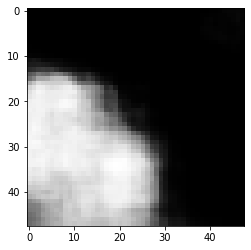

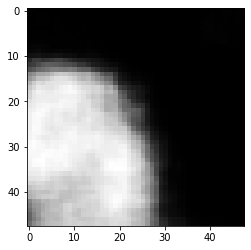

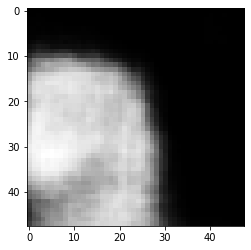

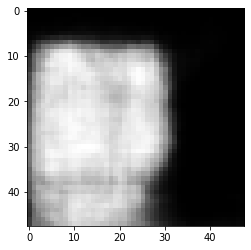

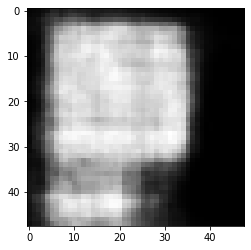

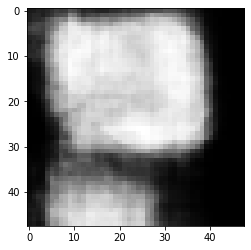

In [113]:
from cv2 import VideoWriter
import cv2
from matplotlib import pyplot as plt

# Abmessungen und Bildrate:
width, height = 48, 48
frame_rate = 10

# Der Codec. Mit diesem hier haben wir gute Erfahrungen gemacht:
codec = cv2.VideoWriter_fourcc(*'mp4v')

# So initialisieren wir den VideoWriter.
# Das erste Argument bestimmt den Pfad zur Ausgabedatei.
# Achtung: Die Abmessungen werden hier in der üblichen Reihenfolge geschrieben,
# also (Breite, Höhe) - also nicht so, wie wir es von NumPy Arrays gewohnt sind.
out = VideoWriter('film.mp4', codec, frame_rate, (width, height))

input = gen[0][0][4]


for _ in range(200):
  img = input[-1]
  plt.imshow(img, cmap='gray')
  plt.show()
  input = dream_step(model, input)
  img8bit = (img * 255.0).astype("uint8")
  img8bit = np.stack((img8bit,)*3, axis=-1)
  black_image = np.zeros((height, width, 3), "uint8")
  out.write(img8bit)
  
out.release()
cv2.destroyAllWindows()

### Versuche zur Unschärfe

In [ ]:
from scipy import ndimage

def single_blurriness(img_as_np_array):  
  return 1.0 / ndimage.laplace(img_as_np_array).var()

def batch_blurriness(y_pred, factor=0.0001):
  result = 0;
  n_images = y_pred.shape[0]
  for i in range(n_images):
    blurriness = single_blurriness(y_pred[i])
    result = result + blurriness
  return result * factor

batch_blurriness(y_pred)

12.99995706480626